TODO:

- [x] Validate the duration of the audio files
* Process the audio files and inspect for audio quality
* Analyze duration per image

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import pandas as pd
import speechmetrics as sm
from tqdm.auto import tqdm
import traceback

import sys
import seaborn as sn

sys.path.append("..")
from sgs_utils.path_conf import (
    speech_data_root_dir,
    loc_data_dir,
)

speech_data_session_dir = speech_data_root_dir.joinpath('backup')

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [5]:
df_session = pd.read_parquet(loc_data_dir.joinpath('df_session_tot_cleaned.parquet'))

## Extracting the metrics

In [4]:
metrics = sm.load('absolute', 5)

1 Physical GPUs, 1 Logical GPUs
Loaded  speechmetrics.absolute.mosnet
Loaded  speechmetrics.absolute.srmr


In [7]:
metric_list = []
for _, r in tqdm(df_session.iterrows(), total=len(df_session)):
    if r.wav_duration_s < 5:
        continue

    wav_path = list(
        speech_data_session_dir.glob(f"*{r.ID}/{r.DB}/{r.pic_name}*{r.time_str}*.wav")
    )[0]
    try:
        metric_dict = metrics(str(wav_path), rate=r.wav_sample_rate)

        metric_dict = {
            f"{k}_{i}": v[i] for k, v in metric_dict.items() for i in range(len(v))
        }
        # will be used to merge
        metric_dict["ID"] = r.ID
        metric_dict["DB"] = r.DB
        metric_dict["time_str"] = r.time_str

        metric_list.append(metric_dict)
    except KeyboardInterrupt:
        break
    except:
        traceback.print_exc()
        continue


  0%|          | 0/3194 [00:00<?, ?it/s]

/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/speechmetrics/absolute/srmr/srmr.py:89: RuntimeWarning: invalid value encountered in true_divide
  AC_perc = AC_energy*100/total_energy
Traceback (most recent call last):
  File "/tmp/ipykernel_44296/1292355683.py", line 10, in <cell line: 2>
    metric_dict = metrics(str(wav_path), rate=r.wav_sample_rate)
  File "/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/speechmetrics/__init__.py", line 117, in __call__
    result_metric = metric.test(*files, array_rate=rate)
  File "/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/speechmetrics/__init__.py", line 88, in test
    result_t = self.test_window([audio[win] for audio in audios],
  File "/home/jonas/.cache/pypoetry/virtualenvs/semi-guided-speech-27YL4uf1-py3.8/lib/python3.8/site-packages/speechmetrics/absolute/srmr/__init__.py", 

In [8]:
df_metric = pd.DataFrame(metric_list)
# del wav_path, metric_dict, metric_list, r

In [9]:
df_metric.to_parquet(loc_data_dir.joinpath('df_metric.parquet'))

## Analyzing the metrics

In [10]:
df_metric = pd.read_parquet(loc_data_dir.joinpath('df_metric.parquet'))

In [11]:
df_metric['nb_metrics'] = df_metric.filter(like='srmr').apply(lambda x: sum(x.notna()), axis=1)

In [12]:
df_session_metric = pd.merge(df_session, df_metric, on=['ID', 'DB', 'time_str'], how='left')

In [13]:
df_session_metric['wav_metric_ratio'] = df_session_metric['wav_duration_s'] / df_session_metric['nb_metrics']

It appears we have a metric each 5s of data

<AxesSubplot:ylabel='Frequency'>

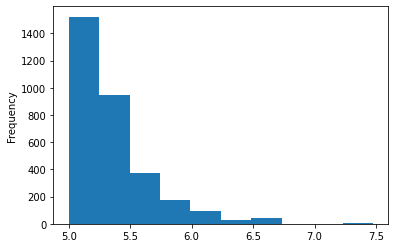

In [14]:
df_session_metric[df_session_metric.wav_duration_s > 10].wav_metric_ratio.plot.hist()

<AxesSubplot:ylabel='Frequency'>

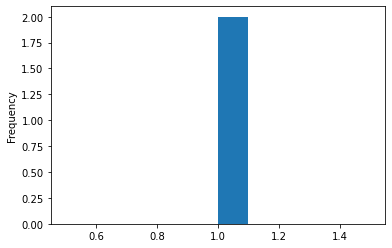

In [19]:
df_session_metric[(df_session_metric.wav_duration_s > 5) & (df_session_metric.wav_duration_s < 9.9)].nb_metrics.plot.hist()

<AxesSubplot:ylabel='Frequency'>

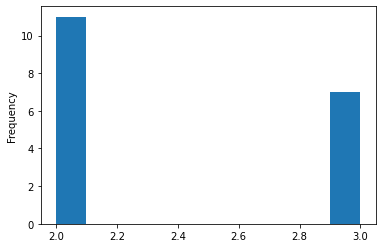

In [28]:
df_session_metric[(df_session_metric.wav_duration_s > 10) & (df_session_metric.wav_duration_s < )].nb_metrics.plot.hist()

### mosnet

<AxesSubplot:ylabel='Density'>

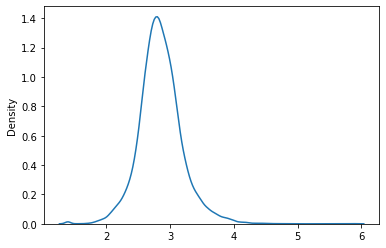

In [29]:
sn.kdeplot(df_metric.filter(like='mosnet').values.ravel())

<AxesSubplot:ylabel='Density'>

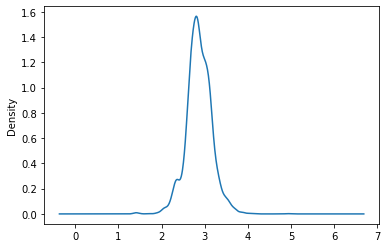

In [30]:
df_metric.filter(like='mosnet').mean(axis=1).plot.kde()

<AxesSubplot:ylabel='Density'>

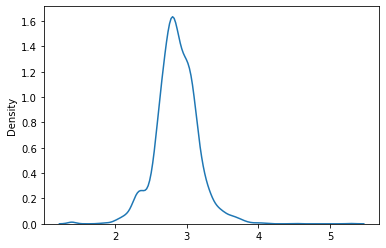

In [31]:
sn.kdeplot(df_metric.filter(like='mosnet').median(axis=1))

<AxesSubplot:ylabel='Density'>

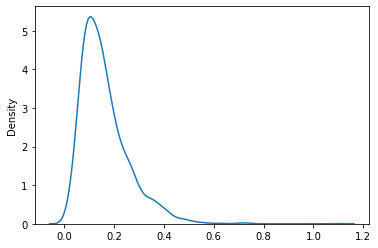

In [32]:
sn.kdeplot(df_metric.filter(like='mosnet').std(axis=1))

### srmr

<AxesSubplot:ylabel='Density'>

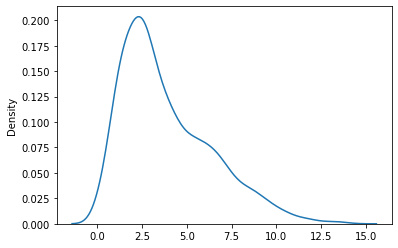

In [33]:
sn.kdeplot(df_metric.filter(like='srmr').min(axis=1))

<AxesSubplot:ylabel='Density'>

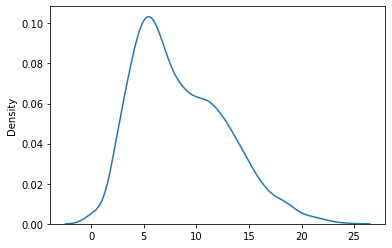

In [34]:
sn.kdeplot(df_metric[df_metric.filter(like='srmr').max(axis=1) < 25].filter(like='srmr').max(axis=1))

<AxesSubplot:ylabel='Density'>

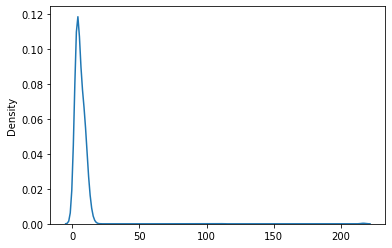

In [35]:
sn.kdeplot(df_metric.filter(like='srmr').median(axis=1))

## Filtering df session metric

In [36]:
df_session_metric[
    # (df_session_metric.wav_duration_s > 8) &
    (df_session_metric.filter(like='mosnet').min(axis=1) < 1.5) 
 & ~(df_session_metric.filter(like='mosnet').mean(axis=1) < 2)
][['ID', 'timestamp', 'DB', 'pic_name', 'time_str']]

,ID,timestamp,DB,pic_name,time_str
2731,d7fbc4b9-5f94-4639-b82b-6b1592b2ad3a,2022-06-29 19:34:02.048344+02:00,PiSCES,Picture 80,19:57:47


<AxesSubplot:>

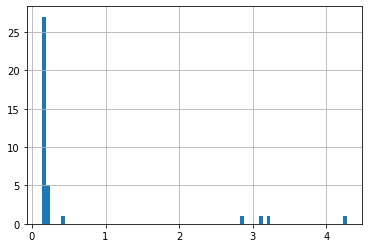

In [37]:
# a lot of silent / no audio sessions
df_session_metric[df_session_metric.ID == '42c842a5-7051-44c3-af42-cf824fded959'].filter(like='srmr').median(axis=1).hist(bins=80)

In [44]:
valid_mask = (
    (df_session_metric.wav_duration_s > 15) &
    # totally silent; no speech at all
    # (df_session_metric.filter(like='srmr').quantile(q=0.85, axis=1) > 40)
    # (df_session_metric.filter(like='srmr').apply(lambda x: x[x.notna()][1:-1].mean(), axis=1) > 18)
    # determined heuristically -> seemed like a good estimate
    ~((df_session_metric.filter(like='mosnet').mean(axis=1) < 2)
    | (df_session_metric.filter(like='mosnet').min(axis=1) < 1.5) 
    | (df_session_metric.filter(like='srmr').median(axis=1) < 0.5) 
    )
)

In [47]:
df_session_metric[
    (df_session_metric.wav_duration_s > 17) &
    # totally silent; no speech at all
    # (df_session_metric.filter(like='srmr').quantile(q=0.85, axis=1) > 40)
    # (df_session_metric.filter(like='srmr').apply(lambda x: x[x.notna()][1:-1].mean(), axis=1) > 18)
    # determined heuristically -> seemed like a good estimate
    ((df_session_metric.filter(like='mosnet').mean(axis=1) < 2)
    | (df_session_metric.filter(like='mosnet').min(axis=1) < 1.5) 
    | (df_session_metric.filter(like='srmr').median(axis=1) < 0.5) 
    )
][['ID', 'timestamp', 'DB', 'pic_name', 'wav_duration_s', 'time_str']]

,ID,timestamp,DB,pic_name,wav_duration_s,time_str
74,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,2022-06-27 22:01:48.323990+02:00,PiSCES,Picture 81,91.05,22:13:27
75,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,2022-06-27 22:01:48.323990+02:00,Radboud,Rafd090_58_Caucasian_female_neutral_frontal,67.24,22:14:45
77,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,2022-06-27 22:01:48.323990+02:00,Radboud,Rafd090_04_Caucasian_female_neutral_frontal,70.49,22:17:13
81,0c28e160-d7bb-4b17-829c-c9ebc7ad0a1f,2022-06-27 22:01:48.323990+02:00,PiSCES,Picture 105,54.10,22:21:22
845,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,Radboud,Rafd090_46_Caucasian_male_neutral_frontal,59.05,14:22:30
848,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,PiSCES,Picture 93,83.20,14:26:44
849,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,marloes,marloes,25.94,14:27:22
850,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,Radboud,Rafd090_24_Caucasian_male_neutral_frontal,58.62,14:28:30
851,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,PiSCES,Picture 56,95.32,14:30:13
852,42c842a5-7051-44c3-af42-cf824fded959,2022-06-29 14:11:06.409834+02:00,Radboud,Rafd090_05_Caucasian_male_neutral_frontal,49.83,14:31:12
